# Описание датасета

## Датасет содержит 7930 изображений скинов Minecraft, где каждая строка соответствует одному файлу изображения.

# Импорты

In [292]:
import kagglehub
import shutil
from pathlib import Path

from PIL import Image, UnidentifiedImageError
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from typing import Optional

# Конфигурационные переменные

In [293]:
skins_dataset_path = Path("minecraft_skins_analysis/skins")
skins_dataset_path.mkdir(parents=True, exist_ok=True)

# Скачивание датасета

In [294]:
src_path = Path(kagglehub.dataset_download("alxmamaev/minecraft-skins"))

print("Датасет успешно сохранён в", src_path.absolute())

for file in src_path.rglob("*"):
    if file.is_file() and file.suffix.lower() in (".png", ".jpg"):
        target = skins_dataset_path / file.name

        # counter = 1
        #
        # while target.exists():
        #     target = dst_path / f"{file.stem}_{counter}{file.suffix}"
        #
        #     counter += 1

        shutil.move(str(file), str(target))

shutil.rmtree(src_path, ignore_errors=True)

print("Датасет успешно перемещён в", skins_dataset_path.absolute())

Resuming download from 5242880 bytes (29739404 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/alxmamaev/minecraft-skins?dataset_version_number=1 (5242880/34982284) bytes left.


100%|██████████| 33.4M/33.4M [00:02<00:00, 10.1MB/s]

Extracting files...


Датасет успешно сохранён в C:\Users\HYPERPC\.cache\kagglehub\datasets\alxmamaev\minecraft-skins\versions\1
Датасет успешно перемещён в D:\Python\PyCharm\Projects\Learn\AP\L_4\minecraft_skins_analysis\skins


# Подготовка датасета

In [295]:
data = []
files_count = 0
skipped_files_count = 0

for file in skins_dataset_path.iterdir():
    if not file.is_file() or file.suffix.lower() not in (".png", ".jpg"):
        continue

    try:
        img = Image.open(file.absolute())

        img = img.resize((64, 64), Image.Resampling.NEAREST)

        img = img.convert("RGBA")

        img_array = np.array(img)

        h, w, _ = img_array.shape
        pixels = h * w

        r = img_array[:, :, 0]
        g = img_array[:, :, 1]
        b = img_array[:, :, 2]
        a = img_array[:, :, 3]

        # Цвет
        r_mean, g_mean, b_mean = r.mean(), g.mean(), b.mean()
        r_std, g_std, b_std = r.std(), g.std(), b.std()

        # Яркость
        brightness = 0.299 * r + 0.587 * g + 0.114 * b
        brightness_mean = brightness.mean()
        brightness_std = brightness.std()

        # Цветастость
        rg = np.abs(r - g)
        yb = np.abs(0.5 * (r + g) - b)
        colorfulness = np.sqrt(rg.mean() ** 2 + yb.mean() ** 2)

        # Альфа
        alpha_mean = a.mean()
        alpha_std = a.std()
        alpha_ratio = np.count_nonzero(a < 255) / pixels

        # Уникальные цвета
        unique_colors = len(
            np.unique(img_array[:, :, :3].reshape(-1, 3), axis=0)
        )

        # Резкость
        gx = np.abs(np.diff(brightness, axis=1)).mean()
        gy = np.abs(np.diff(brightness, axis=0)).mean()
        edge_strength = gx + gy

        data.append([
            file, "RGBA", w, h, pixels,
            r_mean, g_mean, b_mean,
            r_std, g_std, b_std,
            brightness_mean, brightness_std,
            colorfulness,
            alpha_mean, alpha_std, alpha_ratio,
            unique_colors,
            edge_strength
        ])

        files_count += 1

    except (UnidentifiedImageError, OSError) as ex:
        skipped_files_count += 1
        print(f"{skipped_files_count}: Пропущен файл: {file}\n\tТекст ошибки: {ex}")
        continue

df = pd.DataFrame(
    data,
    columns=[
        "filename", "format",
        "width", "height", "pixels",
        "R_mean", "G_mean", "B_mean",
        "R_std", "G_std", "B_std",
        "brightness_mean", "brightness_std",
        "colorfulness",
        "Alpha_mean", "Alpha_std", "Alpha_ratio",
        "unique_colors",
        "edge_strength"
    ]
)

print(f"Всего обработано файлов: {files_count}")
print(f"Пропущено: {skipped_files_count}")

1: Пропущен файл: minecraft_skins_analysis\skins\2829.jpg
	Текст ошибки: cannot identify image file 'D:\\Python\\PyCharm\\Projects\\Learn\\AP\\L_4\\minecraft_skins_analysis\\skins\\2829.jpg'
2: Пропущен файл: minecraft_skins_analysis\skins\4031.jpg
	Текст ошибки: cannot identify image file 'D:\\Python\\PyCharm\\Projects\\Learn\\AP\\L_4\\minecraft_skins_analysis\\skins\\4031.jpg'
3: Пропущен файл: minecraft_skins_analysis\skins\5148.jpg
	Текст ошибки: cannot identify image file 'D:\\Python\\PyCharm\\Projects\\Learn\\AP\\L_4\\minecraft_skins_analysis\\skins\\5148.jpg'
4: Пропущен файл: minecraft_skins_analysis\skins\5329.jpg
	Текст ошибки: cannot identify image file 'D:\\Python\\PyCharm\\Projects\\Learn\\AP\\L_4\\minecraft_skins_analysis\\skins\\5329.jpg'
5: Пропущен файл: minecraft_skins_analysis\skins\563.jpg
	Текст ошибки: cannot identify image file 'D:\\Python\\PyCharm\\Projects\\Learn\\AP\\L_4\\minecraft_skins_analysis\\skins\\563.jpg'
6: Пропущен файл: minecraft_skins_analysis\skin

## Описание параметров

### Общая информация
- **filename** - имя файла изображения скина
- **format** - формат изображения (обычно `RGBA` для скинов Minecraft)

### Геометрия изображения
- **width** - ширина изображения в пикселях (обычно `64` или `128`)
- **height** - высота изображения в пикселях (обычно `64` или `128`)
- **pixels** - общее количество пикселей (`width × height`)

### Цветовые характеристики
- **R_mean** - среднее значение красного канала (`0-255`)
- **G_mean** - среднее значение зелёного канала (`0-255`)
- **B_mean** - среднее значение синего канала (`0-255`)

- **R_std** - стандартное отклонение красного канала
- **G_std** - стандартное отклонение зелёного канала
- **B_std** - стандартное отклонение синего канала

### Яркость и контраст
- **brightness_mean** - средняя яркость изображения (`0-255`)
- **brightness_std** - стандартное отклонение яркости (контраст изображения)

### Насыщенность
- **colorfulness** - мера насыщенности цветов

### Alpha-канал
- **Alpha_mean** - среднее значение альфа-канала (общий уровень прозрачности)
- **Alpha_std** - вариативность прозрачности
- **Alpha_ratio** - доля пикселей с прозрачностью (`alpha < 255`)

### Структура и детализация
- **unique_colors** - количество уникальных RGB-цветов (показатель детализации скина)
- **edge_strength** - сила границ (градиенты яркости, мера резкости и количества деталей)


# Содержимое

In [320]:
df

,filename,format,width,height,pixels,R_mean,G_mean,B_mean,R_std,G_std,B_std,brightness_mean,brightness_std,colorfulness,Alpha_mean,Alpha_std,Alpha_ratio,unique_colors,edge_strength
0,minecraft_skins_analysis\skins\1.jpg,RGBA,64,64,4096,94.868652,79.238281,66.857422,91.206148,81.773332,73.542791,82.500344,82.956703,47.530482,152.192871,124.936251,0.403809,55,23.378328
1,minecraft_skins_analysis\skins\10.jpg,RGBA,64,64,4096,75.730469,64.993652,57.070312,92.016335,84.210682,75.960811,67.300700,83.837695,69.138526,121.895508,127.375331,0.522217,75,50.213296
2,minecraft_skins_analysis\skins\100.jpg,RGBA,64,64,4096,19.266846,18.496826,18.506348,46.443586,42.638378,42.056660,18.728147,43.685586,4.011607,111.811523,126.531110,0.561523,15,16.955506
3,minecraft_skins_analysis\skins\1000.jpg,RGBA,64,64,4096,58.833008,54.484375,53.404297,83.684836,80.267465,80.182334,55.661487,80.097615,31.307749,147.421875,125.933986,0.421875,52,17.208200
4,minecraft_skins_analysis\skins\1001.jpg,RGBA,64,64,4096,83.641602,65.671143,72.402588,103.985860,95.669049,95.983017,71.811695,94.485842,63.125548,122.581787,127.405107,0.519287,37,40.572299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7918,minecraft_skins_analysis\skins\995.jpg,RGBA,64,64,4096,73.864990,69.503418,39.288086,109.232441,103.477140,57.120871,67.362980,99.597201,9.050240,119.157715,127.226791,0.532715,36,30.078780
7919,minecraft_skins_analysis\skins\996.jpg,RGBA,64,64,4096,82.761230,79.168213,78.062012,98.070554,96.545598,98.348608,80.116418,96.903287,58.582359,116.854248,127.054783,0.541748,90,58.927761
7920,minecraft_skins_analysis\skins\997.jpg,RGBA,64,64,4096,18.443848,11.168457,15.200439,34.592603,25.020732,29.312294,13.803445,26.221186,10.157183,116.169678,126.948558,0.544678,138,11.826005
7921,minecraft_skins_analysis\skins\998.jpg,RGBA,64,64,4096,65.744141,53.408691,51.826416,81.361285,74.664049,72.109163,56.916611,75.971781,27.932229,133.850098,127.341770,0.475098,54,32.227314


# Визуализация

## Яркость и насыщенность

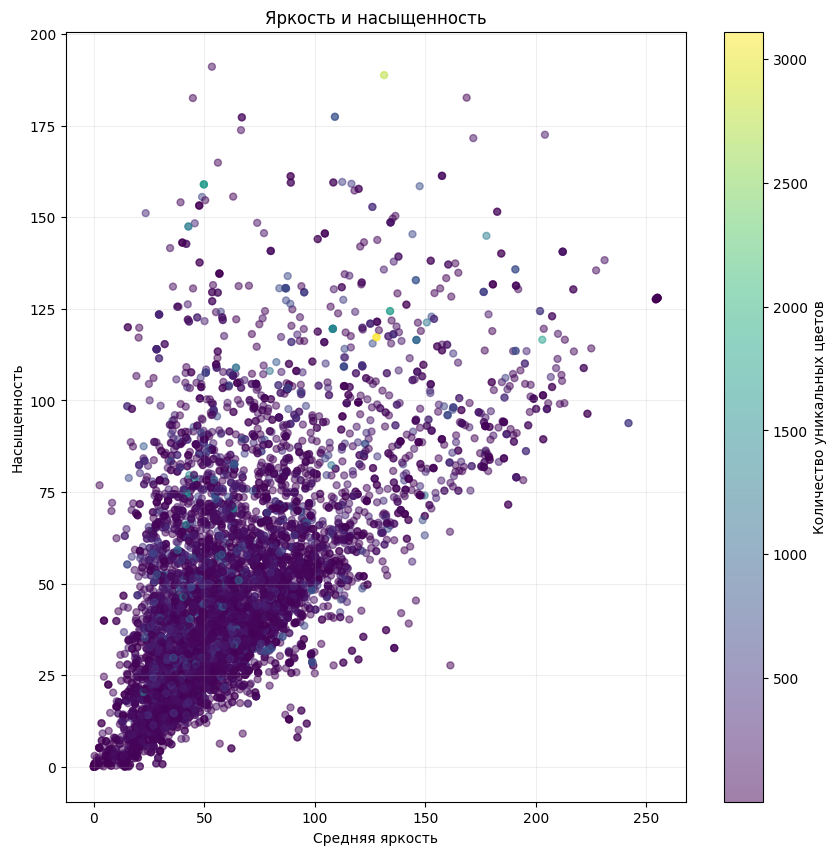

In [296]:
plt.figure(figsize=(10, 10))

scatter = plt.scatter(
    df["brightness_mean"],
    df["colorfulness"],
    c=df["unique_colors"],
    cmap="viridis", alpha=0.5, s=25
)
plt.colorbar(scatter, label="Количество уникальных цветов")
plt.title("Яркость и насыщенность")
plt.xlabel("Средняя яркость")
plt.ylabel("Насыщенность")
plt.grid(alpha=0.2)
plt.show()

## Распределение количества уникальных цветов

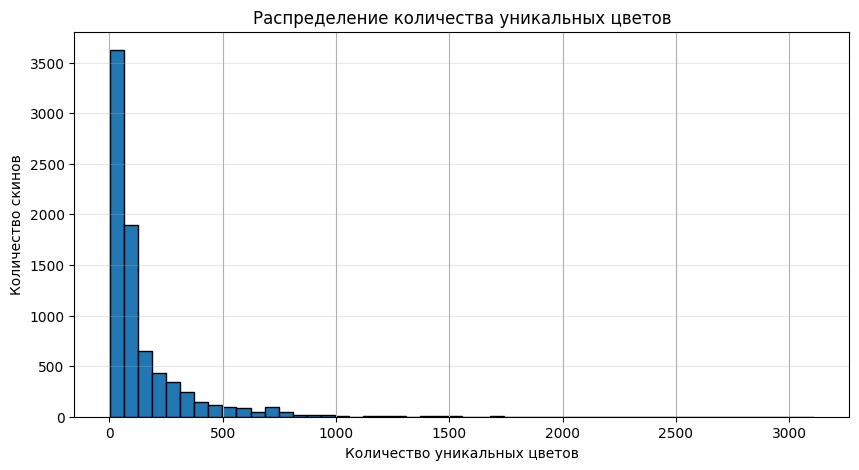

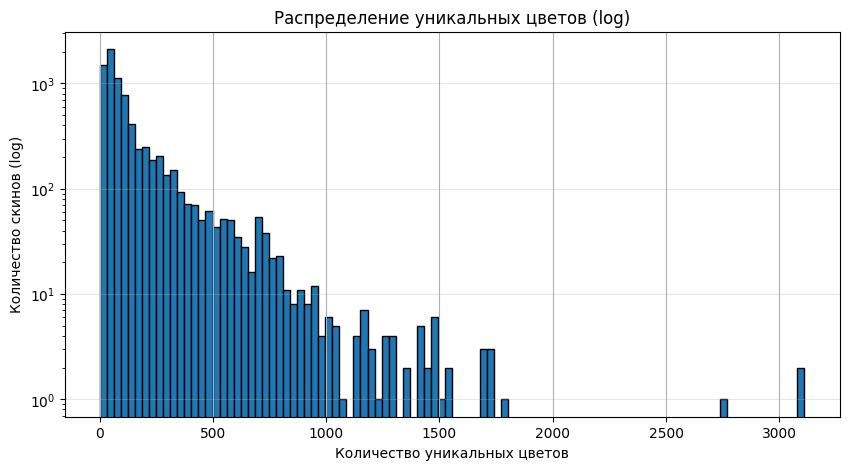

In [297]:
plt.figure(figsize=(10, 5))
df["unique_colors"].hist(bins=50, edgecolor="black")
plt.title("Распределение количества уникальных цветов")
plt.xlabel("Количество уникальных цветов")
plt.ylabel("Количество скинов")
plt.grid(axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
df["unique_colors"].hist(bins=100, edgecolor="black", log=True)
plt.title("Распределение уникальных цветов (log)")
plt.xlabel("Количество уникальных цветов")
plt.ylabel("Количество скинов (log)")
plt.grid(axis="y", alpha=0.3)
plt.show()

## Резкость и количество уникальных цветов

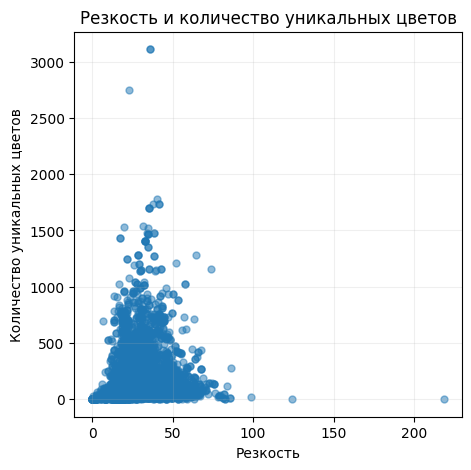

In [298]:
plt.figure(figsize=(5, 5))
plt.scatter(df["edge_strength"], df["unique_colors"], alpha=0.5, s=25)
plt.title("Резкость и количество уникальных цветов")
plt.xlabel("Резкость")
plt.ylabel("Количество уникальных цветов")
plt.grid(alpha=0.2)
plt.show()

## Alpha-канал

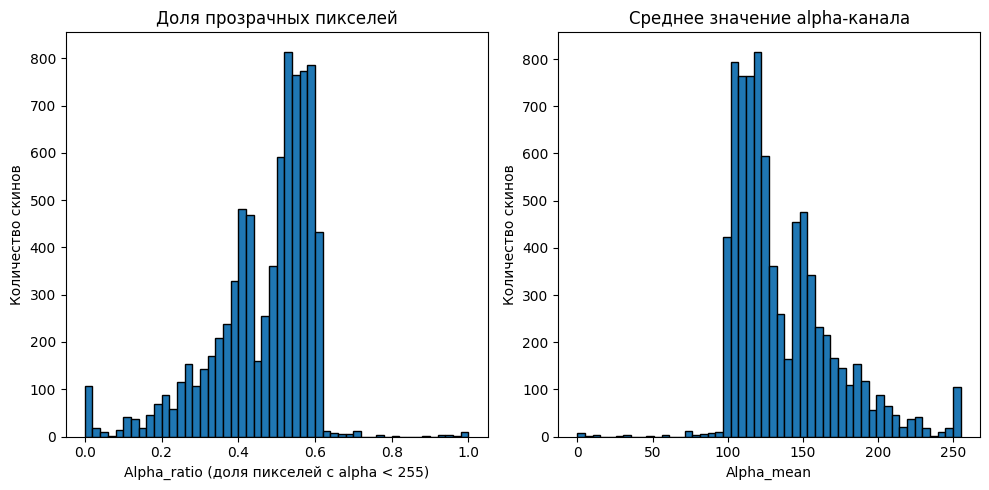

In [299]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(df["Alpha_ratio"], bins=50, edgecolor="black")
axes[0].set_title("Доля прозрачных пикселей")
axes[0].set_xlabel("Alpha_ratio (доля пикселей с alpha < 255)")
axes[0].set_ylabel("Количество скинов")

axes[1].hist(df["Alpha_mean"], bins=50, edgecolor="black")
axes[1].set_title("Среднее значение alpha-канала")
axes[1].set_xlabel("Alpha_mean")
axes[1].set_ylabel("Количество скинов")

plt.tight_layout()
plt.show()

## Распределение средних значений RGB-каналов

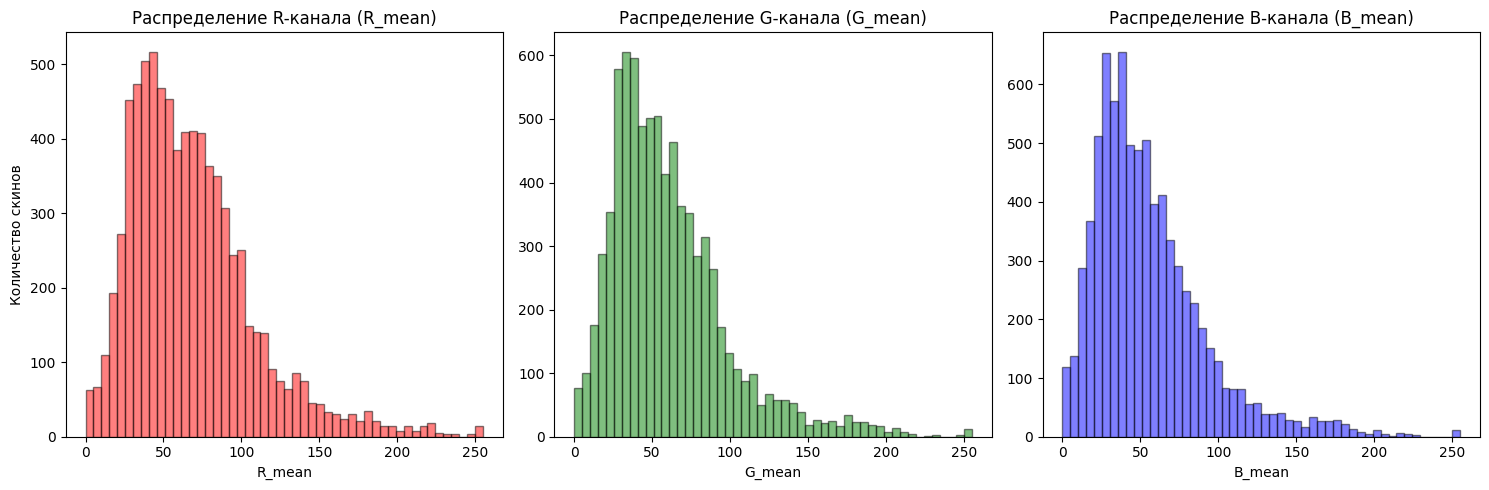

In [300]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df["R_mean"], bins=50, color="red", alpha=0.5, edgecolor="black")
axes[0].set_title("Распределение R-канала (R_mean)")
axes[0].set_xlabel("R_mean")
axes[0].set_ylabel("Количество скинов")

axes[1].hist(df["G_mean"], bins=50, color="green", alpha=0.5, edgecolor="black")
axes[1].set_title("Распределение G-канала (G_mean)")
axes[1].set_xlabel("G_mean")

axes[2].hist(df["B_mean"], bins=50, color="blue", alpha=0.5, edgecolor="black")
axes[2].set_title("Распределение B-канала (B_mean)")
axes[2].set_xlabel("B_mean")

plt.tight_layout()
plt.show()

## Суперпозиция средних значений RGB-каналов

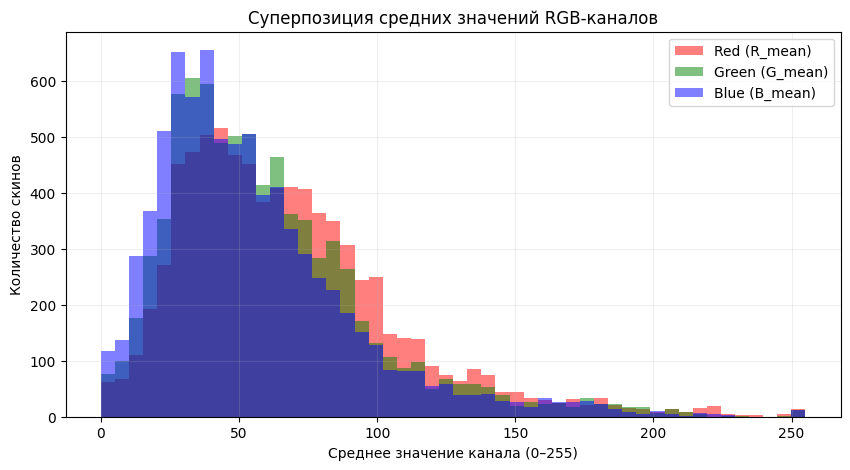

In [301]:
plt.figure(figsize=(10, 5))
plt.hist(df["R_mean"], bins=50, alpha=0.5, label="Red (R_mean)", color="red")
plt.hist(df["G_mean"], bins=50, alpha=0.5, label="Green (G_mean)", color="green")
plt.hist(df["B_mean"], bins=50, alpha=0.5, label="Blue (B_mean)", color="blue")
plt.title("Суперпозиция средних значений RGB-каналов")
plt.xlabel("Среднее значение канала (0–255)")
plt.ylabel("Количество скинов")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## Распределение стандартных отклонений значений RGB-каналов

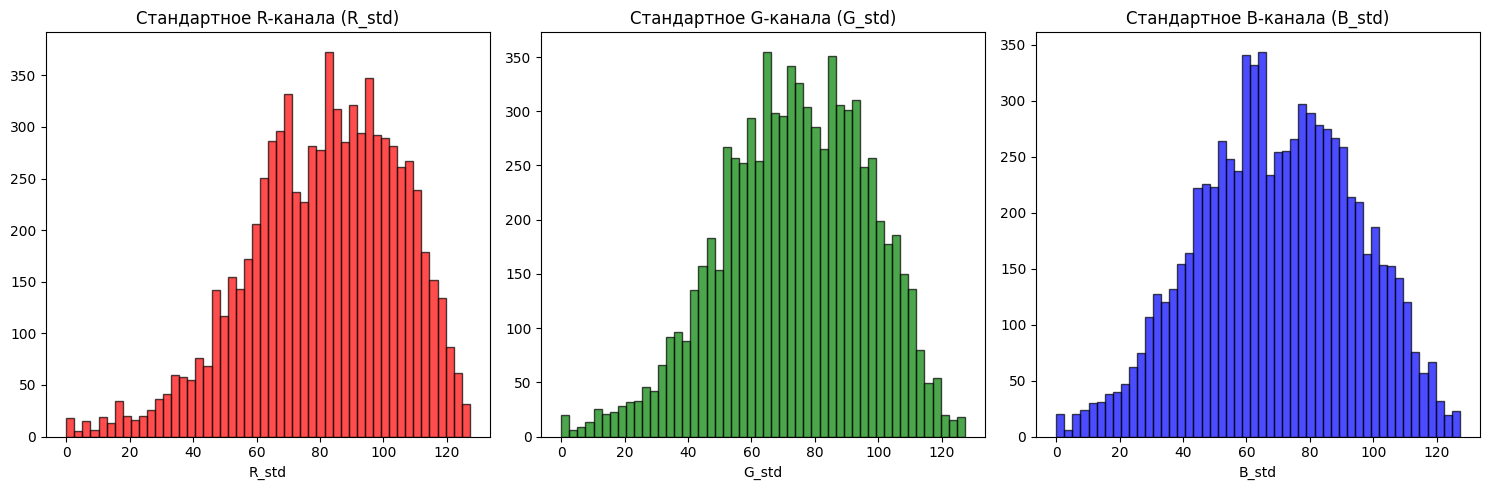

In [312]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df["R_std"], bins=50, color="red", alpha=0.7, edgecolor="black")
axes[0].set_title("Стандартное R-канала (R_std)")
axes[0].set_xlabel("R_std")

axes[1].hist(df["G_std"], bins=50, color="green", alpha=0.7, edgecolor="black")
axes[1].set_title("Стандартное G-канала (G_std)")
axes[1].set_xlabel("G_std")

axes[2].hist(df["B_std"], bins=50, color="blue", alpha=0.7, edgecolor="black")
axes[2].set_title("Стандартное B-канала (B_std)")
axes[2].set_xlabel("B_std")

plt.tight_layout()
plt.show()

## Распределение яркости и контрастности

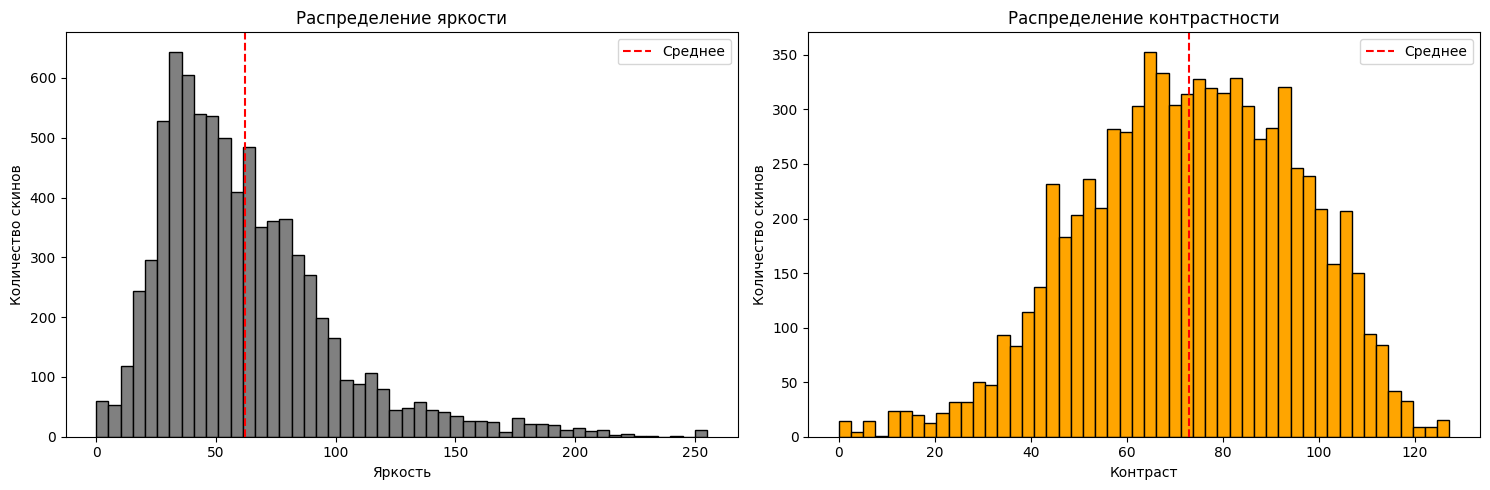

In [313]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df["brightness_mean"], bins=50, color="gray", edgecolor="black")
axes[0].set_title("Распределение яркости")
axes[0].set_xlabel("Яркость")
axes[0].set_ylabel("Количество скинов")
axes[0].axvline(df["brightness_mean"].mean(), color="red", linestyle="--", label="Среднее")
axes[0].legend()

axes[1].hist(df["brightness_std"], bins=50, color="orange", edgecolor="black")
axes[1].set_title("Распределение контрастности")
axes[1].set_xlabel("Контраст")
axes[1].set_ylabel("Количество скинов")
axes[1].axvline(df["brightness_std"].mean(), color="red", linestyle="--", label="Среднее")
axes[1].legend()

plt.tight_layout()
plt.show()

## Цветовой баланс

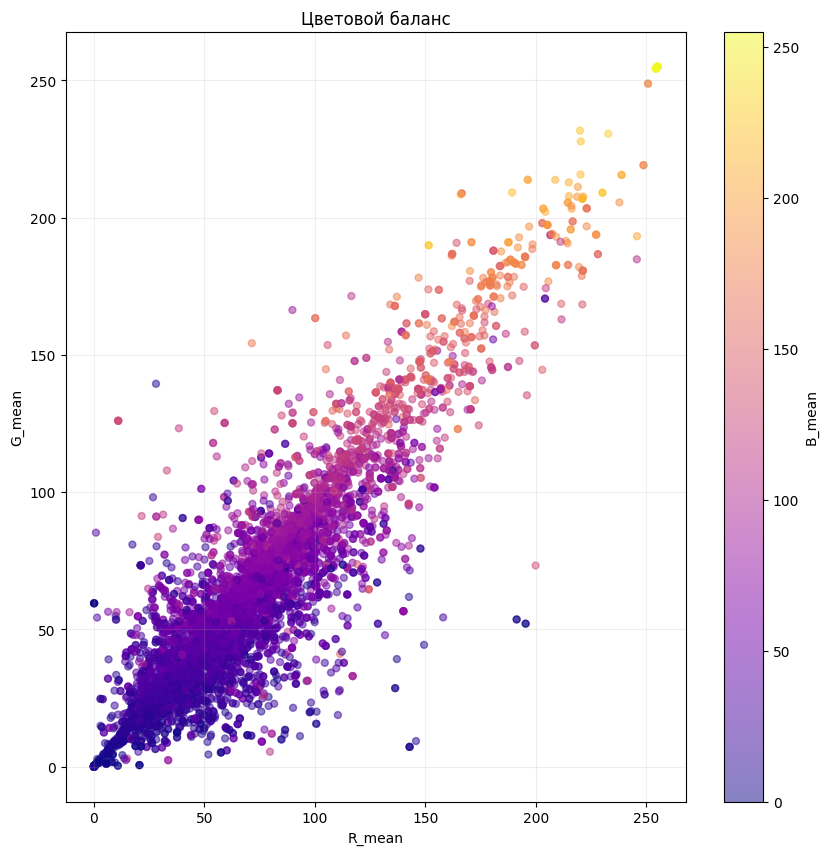

In [314]:
plt.figure(figsize=(10, 10))
plt.scatter(df["R_mean"], df["G_mean"], c=df["B_mean"], cmap="plasma", alpha=0.5, s=25)
plt.colorbar(label="B_mean")
plt.title("Цветовой баланс")
plt.xlabel("R_mean")
plt.ylabel("G_mean")
plt.grid(alpha=0.2)
plt.show()

# Гипотезы

## Информация о датасете

In [321]:
print("Размер датасета:", df.shape)
print("\nОсновная статистика:")
print(df.describe())

Размер датасета: (7923, 19)

Основная статистика:
        width  height  pixels       R_mean       G_mean       B_mean  \
count  7923.0  7923.0  7923.0  7923.000000  7923.000000  7923.000000   
mean     64.0    64.0  4096.0    68.075982    60.587641    55.510137   
std       0.0     0.0     0.0    39.795220    37.557149    36.651285   
min      64.0    64.0  4096.0     0.000000     0.000000     0.000000   
25%      64.0    64.0  4096.0    39.371826    34.253662    29.917969   
50%      64.0    64.0  4096.0    61.321289    52.997070    47.483154   
75%      64.0    64.0  4096.0    87.590210    77.701294    71.521606   
max      64.0    64.0  4096.0   255.000000   255.000000   255.000000   

             R_std        G_std        B_std  brightness_mean  brightness_std  \
count  7923.000000  7923.000000  7923.000000      7923.000000     7923.000000   
mean     81.065175    73.609723    69.582084        62.247819       73.069116   
std      23.775316    23.089592    24.918593        36.945

## Класс для автоматического подтверждения гипотезы

In [322]:
class HypothesisChecker:
    """Класс для автоматического подтверждения гипотезы."""

    def __init__(self, df, column, lower_bound, upper_bound,
                 hypothesis_name: str = "Гипотеза",
                 threshold: float = 50.0,
                 msg_confirmed: Optional[str] = None,
                 msg_rejected: Optional[str] = None,
                 msg_median_in: Optional[str] = None,
                 msg_median_out: Optional[str] = None
     ):
        self.__df = df
        self.__column = column
        self.__lower = lower_bound
        self.__upper = upper_bound
        self.__hyp_name = hypothesis_name
        self.__threshold = threshold

        self.__msg_confirmed = msg_confirmed or "Большинство объектов попадают в указанный диапазон."
        self.__msg_rejected = msg_rejected or "Значительная часть объектов выходит за пределы диапазона."
        self.__msg_median_in = msg_median_in or f"Медиана также находится в целевом диапазоне [{lower_bound}, {upper_bound}]."
        self.__msg_median_out = msg_median_out or f"Медиана находится ВНЕ целевого диапазона [{lower_bound}, {upper_bound}]."

    def check(self):
        series = self.__df[self.__column]

        print(f"{self.__hyp_name}: {self.__column} обычно в диапазоне [{self.__lower}–{self.__upper}]\n")

        print("Статистика:")
        print(series.describe().round(3))

        in_range = ((series >= self.__lower) & (series <= self.__upper)).mean() * 100

        if in_range >= self.__threshold:
            print(f"\nВывод: {self.__hyp_name} ПОДТВЕРЖДАЕТСЯ ({in_range:.2f}% >= {self.__threshold}%).")
            print(self.__msg_confirmed)
        else:
            print(f"\nВывод: {self.__hyp_name} НЕ ПОДТВЕРЖДАЕТСЯ ({in_range:.2f}% <= {self.__threshold}%).")
            print(self.__msg_rejected)

        median = series.median()
        print(f"Медиана: {median:.1f}")

        if self.__lower <= median <= self.__upper:
            print(self.__msg_median_in)
        else:
            print(self.__msg_median_out)

        print("\n" + "#" * 25 + "\n")

### Подтверждение гипотез

### Гипотеза 1: Доля прозрачных пикселей (Alpha_ratio) обычно 30–60%

Гипотеза 1: Доля прозрачных пикселей (Alpha_ratio) обычно 30–60%


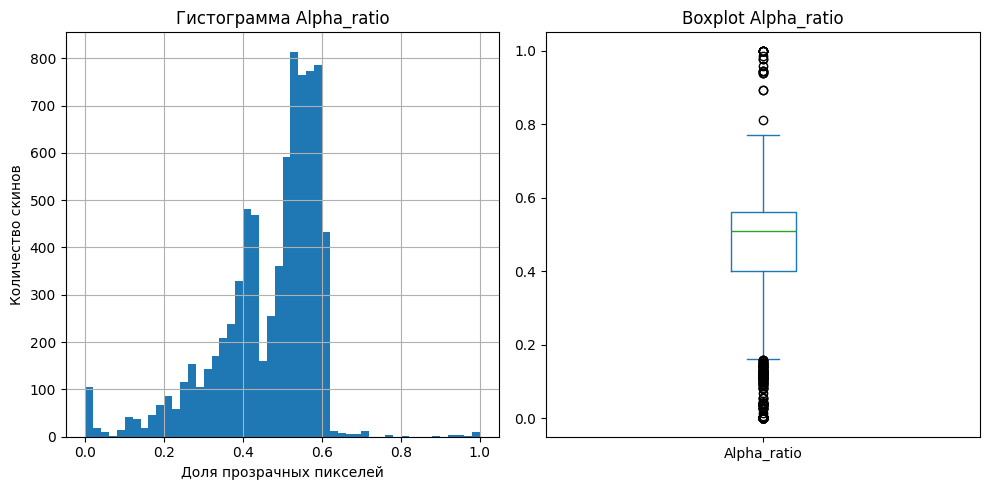

Гипотеза 1: Alpha_ratio обычно в диапазоне [0.3–0.6]

Статистика:
count    7923.000
mean        0.466
std         0.131
min         0.000
25%         0.401
50%         0.510
75%         0.562
max         1.000
Name: Alpha_ratio, dtype: float64

Вывод: Гипотеза 1 ПОДТВЕРЖДАЕТСЯ (82.59% >= 50.0%).
Большинство скинов имеют долю прозрачных пикселей в диапазоне 30–60%.
Медиана: 0.5
Медиана также находится в целевом диапазоне [0.3, 0.6].

#########################



In [323]:
print("Гипотеза 1: Доля прозрачных пикселей (Alpha_ratio) обычно 30–60%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["Alpha_ratio"].hist(bins=50)
plt.title("Гистограмма Alpha_ratio")
plt.xlabel("Доля прозрачных пикселей")
plt.ylabel("Количество скинов")

plt.subplot(1, 2, 2)
df["Alpha_ratio"].plot(kind="box")
plt.title("Boxplot Alpha_ratio")
plt.tight_layout()
plt.show()

checker = HypothesisChecker(
    df=df,
    column="Alpha_ratio",
    lower_bound=0.3,
    upper_bound=0.6,
    hypothesis_name="Гипотеза 1",
    threshold=50.0,
    msg_confirmed="Большинство скинов имеют долю прозрачных пикселей в диапазоне 30–60%.",
    msg_rejected="Значительная часть скинов выходит за пределы диапазона 30–60%."
).check()

### Гипотеза 2: Количество уникальных цветов обычно 20–200

Гипотеза 2: Количество уникальных цветов обычно 20–200


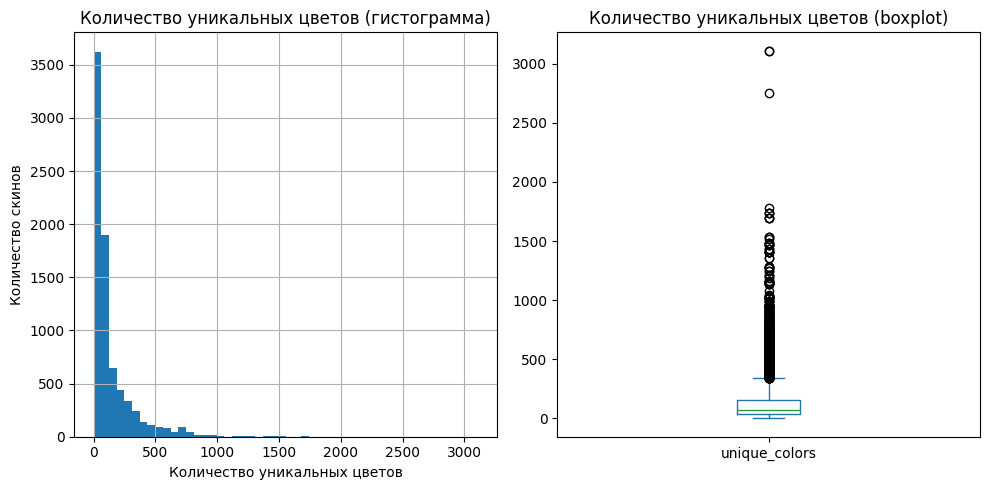

Гипотеза 2: unique_colors обычно в диапазоне [20–200]

Статистика:
count    7923.000
mean      144.192
std       200.428
min         1.000
25%        38.000
50%        72.000
75%       158.000
max      3110.000
Name: unique_colors, dtype: float64

Вывод: Гипотеза 2 ПОДТВЕРЖДАЕТСЯ (70.68% >= 50.0%).
Большинство скинов имеют от 20 до 200 уникальных цветов.
Медиана: 72.0
Медиана также находится в целевом диапазоне [20, 200].

#########################



In [308]:
print("Гипотеза 2: Количество уникальных цветов обычно 20–200")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["unique_colors"].hist(bins=50)
plt.title("Количество уникальных цветов (гистограмма)")
plt.xlabel("Количество уникальных цветов")
plt.ylabel("Количество скинов")

plt.subplot(1, 2, 2)
df["unique_colors"].plot(kind="box")
plt.title("Количество уникальных цветов (boxplot)")
plt.tight_layout()
plt.show()

checker = HypothesisChecker(
    df=df,
    column="unique_colors",
    lower_bound=20,
    upper_bound=200,
    hypothesis_name="Гипотеза 2",
    threshold=50.0,
    msg_confirmed="Большинство скинов имеют от 20 до 200 уникальных цветов.",
    msg_rejected="Значительная часть скинов имеет количество уникальных цветов вне диапазона 20–200."
).check()

### Гипотеза 3: Насыщенность цветов (colorfulness) обычно низкая

Гипотеза 3: Насыщенность цветов (colorfulness) обычно низкая


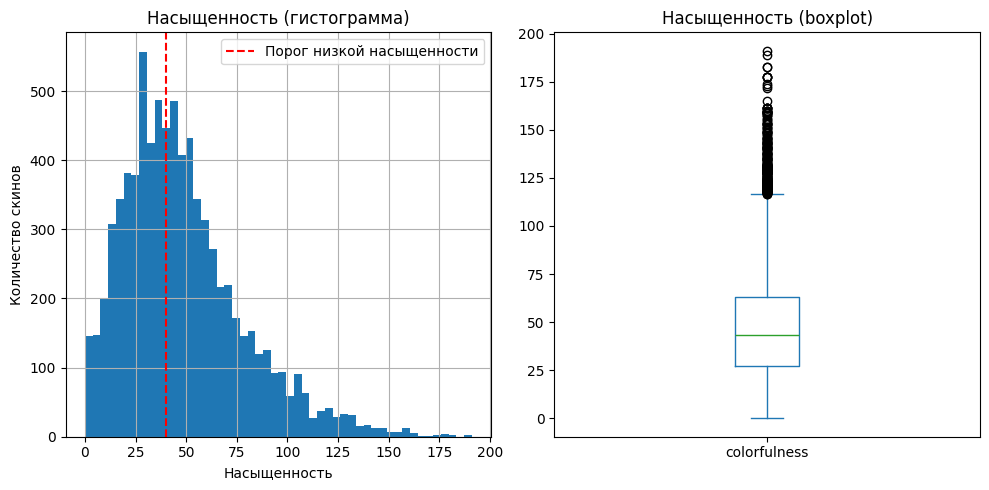

Гипотеза 3: colorfulness обычно в диапазоне [0–40]

Статистика:
count    7923.000
mean       48.160
std        29.491
min         0.000
25%        27.404
50%        43.236
75%        63.070
max       191.128
Name: colorfulness, dtype: float64

Вывод: Гипотеза 3 НЕ ПОДТВЕРЖДАЕТСЯ (45.11% <= 50.0%).
Значительная часть скинов имеет среднюю или высокую насыщенность цветов.
Медиана: 43.2
Медиана находится ВНЕ целевого диапазона [0, 40].

#########################



In [309]:
print("Гипотеза 3: Насыщенность цветов (colorfulness) обычно низкая")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["colorfulness"].hist(bins=50)
plt.title("Насыщенность (гистограмма)")
plt.xlabel("Насыщенность")
plt.ylabel("Количество скинов")
plt.axvline(40, color="red", linestyle="--", label="Порог низкой насыщенности")
plt.legend()

plt.subplot(1, 2, 2)
df["colorfulness"].plot(kind="box")
plt.title("Насыщенность (boxplot)")
plt.tight_layout()
plt.show()

checker = HypothesisChecker(
    df=df,
    column="colorfulness",
    lower_bound=0,
    upper_bound=40,
    hypothesis_name="Гипотеза 3",
    threshold=50.0,
    msg_confirmed="Большинство скинов имеют низкую насыщенность цветов.",
    msg_rejected="Значительная часть скинов имеет среднюю или высокую насыщенность цветов."
).check()

#### Гипотеза 3 (обратная): Насыщенность цветов (colorfulness) обычно низкая

Гипотеза 3 (обратная): Насыщенность цветов (colorfulness) обычно средняя или высокая


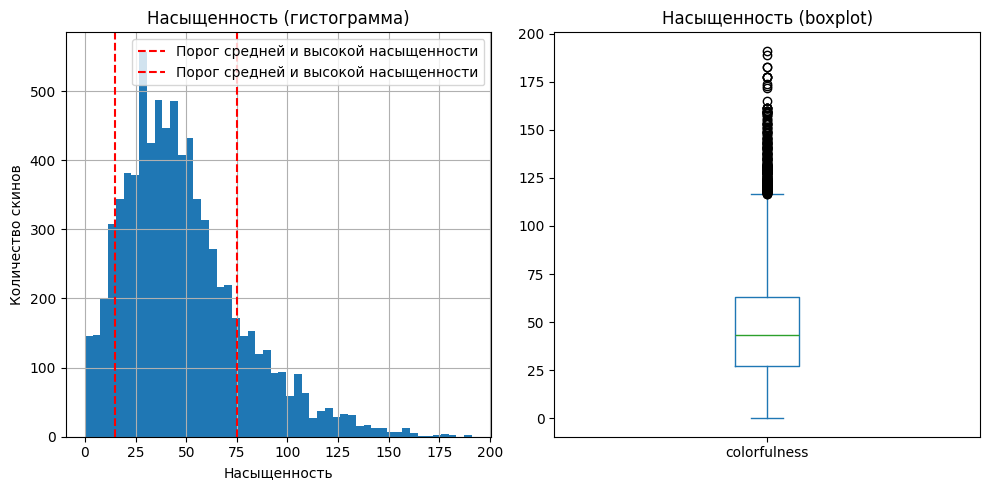

Гипотеза 3: colorfulness обычно в диапазоне [15–75]

Статистика:
count    7923.000
mean       48.160
std        29.491
min         0.000
25%        27.404
50%        43.236
75%        63.070
max       191.128
Name: colorfulness, dtype: float64

Вывод: Гипотеза 3 ПОДТВЕРЖДАЕТСЯ (73.67% >= 50.0%).
Большинство скинов имеют низкую или высокую насыщенность цветов.
Медиана: 43.2
Медиана также находится в целевом диапазоне [15, 75].

#########################



In [318]:
print("Гипотеза 3 (обратная): Насыщенность цветов (colorfulness) обычно средняя или высокая")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["colorfulness"].hist(bins=50)
plt.title("Насыщенность (гистограмма)")
plt.xlabel("Насыщенность")
plt.ylabel("Количество скинов")
plt.axvline(15, color="red", linestyle="--", label="Порог средней и высокой насыщенности")
plt.axvline(75, color="red", linestyle="--", label="Порог средней и высокой насыщенности")
plt.legend()

plt.subplot(1, 2, 2)
df["colorfulness"].plot(kind="box")
plt.title("Насыщенность (boxplot)")
plt.tight_layout()
plt.show()

checker = HypothesisChecker(
    df=df,
    column="colorfulness",
    lower_bound=15,
    upper_bound=75,
    hypothesis_name="Гипотеза 3",
    threshold=50.0,
    msg_confirmed="Большинство скинов имеют низкую или высокую насыщенность цветов.",
    msg_rejected="Значительная часть скинов имеет низкую насыщенность цветов."
).check()

### Гипотеза 4: Резкость (edge_strength) обычно низкая

Гипотеза 4: Резкость (edge_strength) обычно средняя или высокая


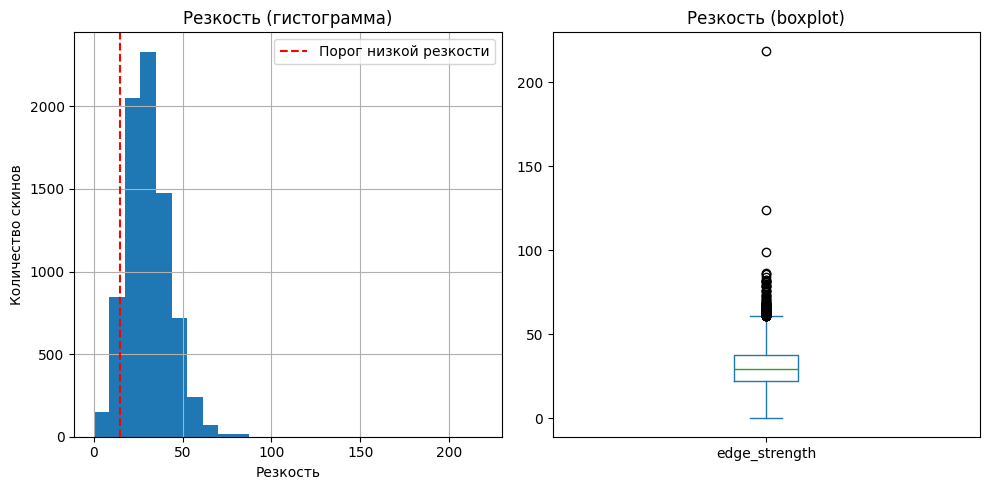

Гипотеза 4: edge_strength обычно в диапазоне [15–219.72186259920636]

Статистика:
count    7923.000
mean       30.466
std        12.210
min         0.000
25%        22.142
50%        29.327
75%        37.660
max       218.722
Name: edge_strength, dtype: float64

Вывод: Гипотеза 4 ПОДТВЕРЖДАЕТСЯ (91.72% >= 50.0%).
Большинство скинов имеют среднюю или высокую резкость (edge_strength).
Медиана: 29.3
Медиана также находится в целевом диапазоне [15, 219.72186259920636].

#########################



In [326]:
print("Гипотеза 4: Резкость (edge_strength) обычно средняя или высокая")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["edge_strength"].hist(bins=25)
plt.title("Резкость (гистограмма)")
plt.xlabel("Резкость")
plt.ylabel("Количество скинов")
plt.axvline(15, color="red", linestyle="--", label="Порог низкой резкости")
plt.legend()

plt.subplot(1, 2, 2)
df["edge_strength"].plot(kind="box")
plt.title("Резкость (boxplot)")
plt.tight_layout()
plt.show()

checker = HypothesisChecker(
    df=df,
    column="edge_strength",
    lower_bound=15,
    upper_bound=df["edge_strength"].max() + 1,
    hypothesis_name="Гипотеза 4",
    msg_confirmed="Большинство скинов имеют среднюю или высокую резкость (edge_strength).",
    msg_rejected="Значительная часть скинов имеет низкую резкость (edge_strength)."
).check()

### Гипотеза 5: Яркость (brightness_mean) обычно средняя

Гипотеза 5: Яркость (brightness_mean) обычно средняя


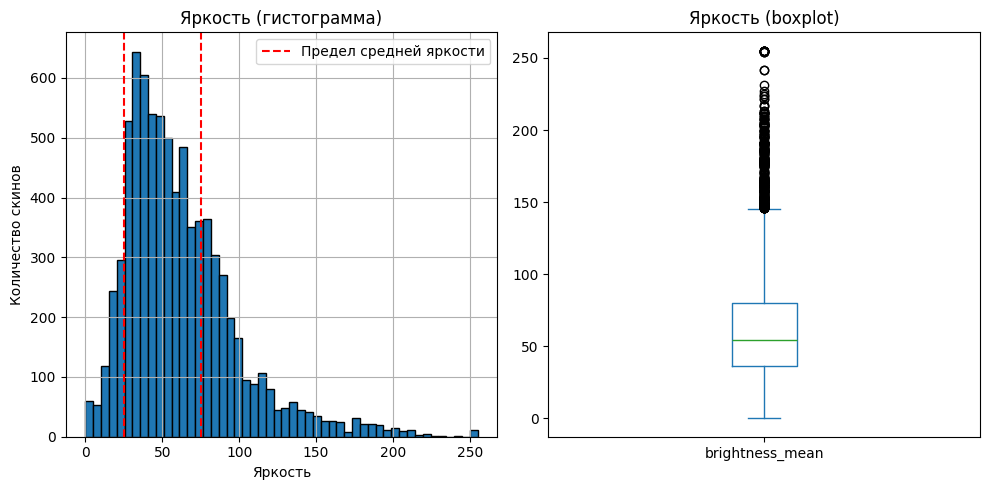

Гипотеза 5: brightness_mean обычно в диапазоне [25–75]

Статистика:
count    7923.000
mean       62.248
std        36.945
min         0.000
25%        35.979
50%        54.374
75%        79.716
max       255.000
Name: brightness_mean, dtype: float64

Вывод: Гипотеза 5 ПОДТВЕРЖДАЕТСЯ (61.98% >= 50.0%).
Большинство скинов имеют среднюю яркость.
Медиана: 54.4
Медиана также находится в целевом диапазоне [25, 75].

#########################



In [319]:
print("Гипотеза 5: Яркость (brightness_mean) обычно средняя")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["brightness_mean"].hist(bins=50, edgecolor="black")
plt.title("Яркость (гистограмма)")
plt.xlabel("Яркость")
plt.ylabel("Количество скинов")
plt.axvline(25, color="red", linestyle="--", label="Предел средней яркости")
plt.axvline(75, color="red", linestyle="--")
plt.legend()

plt.subplot(1, 2, 2)
df["brightness_mean"].plot(kind="box")
plt.title("Яркость (boxplot)")
plt.tight_layout()
plt.show()

checker = HypothesisChecker(
    df=df,
    column="brightness_mean",
    lower_bound=25,
    upper_bound=75,
    hypothesis_name="Гипотеза 5",
    threshold=50.0,
    msg_confirmed="Большинство скинов имеют среднюю яркость.",
    msg_rejected="Значительная часть скинов имеет низкую или высокую яркость."
).check()